In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# ## extract data from xml files into txt files
# import xml.etree.ElementTree as ET

# img_width = 504
# img_height = 747

# base_dir = 'data/custom/labels'
# len = 0
# for xml_file in os.listdir(base_dir):
#     if xml_file.endswith('xml'):
#         len += 1
# # print(len)

# for ind in range(len):
#     xml_file = f'{ind}.xml'
#     root = ET.parse(os.path.join(base_dir, xml_file)).getroot()
#     txt_file = f'{ind}.txt'

#     f = open(os.path.join(base_dir, txt_file), 'w+')
#     for object in root.findall('./object/bndbox'):
#         xmin = int(object[0].text)
#         ymin = int(object[1].text)
#         xmax = int(object[2].text)
#         ymax = int(object[3].text)

#         xcenter = ((xmin + xmax) / 2.0) / img_width
#         ycenter = ((ymin + ymax) / 2.0) / img_height
#         bbox_width = (xmax - xmin) / img_width
#         bbox_height = (ymax - ymin) / img_height

#         f.write(f'0 {xcenter} {ycenter} {bbox_width} {bbox_height}\n')
#         print(f'0 {xcenter} {ycenter} {bbox_width} {bbox_height}')
#     f.close()
#     print('\n')


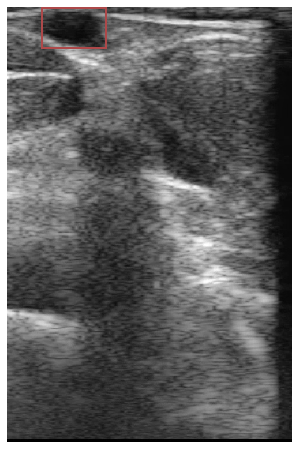

In [7]:
## Model Prediction on Single Image
from yolo_model import Darknet
from datasets import pad_to_square, resize
from utils_yolo import non_max_suppression, rescale_boxes, load_classes

import torch
import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image, ImageChops
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.ticker import NullLocator

# model set up
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Darknet('config/yolov3-custom.cfg', img_size=416).to(device)
model.load_state_dict(torch.load('checkpoints/invivo_91/yolov3_ckpt_38.pth'))
model.eval()

# image preprocessing
img_path = 'data/custom/images/invivo_91/96.jpg'
img = transforms.ToTensor()(Image.open(img_path).convert('L'))
img, _ = pad_to_square(img, 0)
img = resize(img, 416).unsqueeze(0)
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
img_tensor = Variable(img.type(Tensor))

# model prediction
with torch.no_grad():
    detections = model(img_tensor)
    detections = non_max_suppression(detections, conf_thres=0.85, nms_thres=0.35)
# print(f"detections: {detections[0]}")

# result visualization
img_np = np.array(Image.open(img_path))
detections = rescale_boxes(detections[0], 416, img_np.shape[:2])
# print(f"rescaled detections: {detections}")

fig, ax = plt.subplots(1, figsize=(12,8))
ax.imshow(img_np, cmap='gray')
cmap = plt.get_cmap("tab20b")
classes = load_classes('data/custom/classes.names')
for x1, y1, x2, y2, obj_conf, cls_conf, cls_pred in detections:
    # print("\t+ Label: %s, obj_conf: %.5f, cls_conf: %.5f" % (classes[int(cls_pred)], obj_conf.item(), cls_conf.item()))
    x1_draw = max(x1, 2)
    y1_draw = max(y1, 2)
    x2_draw = min(x2, img_np.shape[1] - 2)
    y2_draw = min(y2, img_np.shape[0] - 2)

    color = cmap(13)
    bbox = patches.Rectangle((x1_draw, y1_draw), x2_draw - x1_draw, y2_draw - y1_draw, linewidth=2, edgecolor=color, facecolor="none") # create a rectangle patch
    ax.add_patch(bbox) # add bbox to the plot
    # add label
    # if x1 > 0:
    #     plt.text(x1, y1, s=classes[int(cls_pred)], color="white", verticalalignment="bottom", horizontalalignment='left', bbox={"color": color, "pad": 0})
    # elif x2 < img_np.shape[1]:
    #     plt.text(x2, y2, s=classes[int(cls_pred)], color="white", verticalalignment="top", horizontalalignment='right', bbox={"color": color, "pad": 0})

plt.axis("off")
plt.gca().xaxis.set_major_locator(NullLocator())
plt.gca().yaxis.set_major_locator(NullLocator())
plt.show()

output_path = 'test_trim.jpg'
fig.savefig(output_path, bbox_inches="tight", pad_inches=0.0)


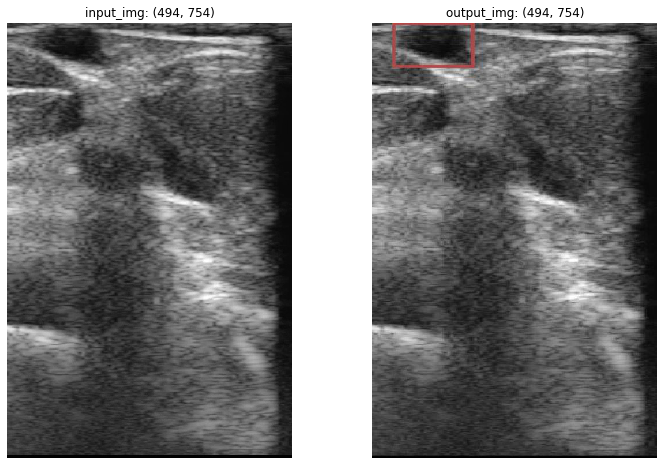

In [10]:
# Visualization Comparison between input_img and output_img -> invivo_91
input_img = Image.open('data/custom/images/invivo_91/96.jpg').convert('L')
output_img = Image.open('output/invivo_91/96.jpg')
# output_img = Image.open('test_trim.jpg')

imgs = [input_img, output_img]
titles = [f'input_img: {input_img.size}', f'output_img: {output_img.size}']
plt.figure(figsize=(12,8))
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

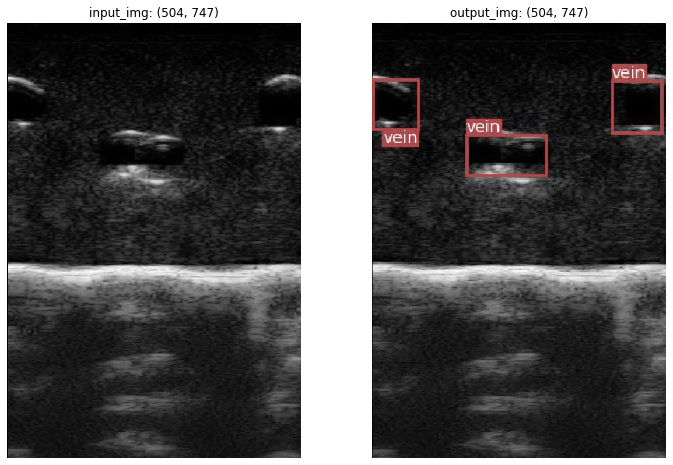

In [19]:
input_img = Image.open('data/custom/images/phantom_20/0.jpg').convert('L')
output_img = Image.open('output/phantom_20/0.jpg')

imgs = [input_img, output_img]
titles = [f'input_img: {input_img.size}', f'output_img: {output_img.size}']
plt.figure(figsize=(12,8))
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1, 2, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

In [11]:
# ### test written functions - model/data confie parsing
# from utils import parse_model_config, load_classes, parse_data_config
# import time
# import datetime

# begin = datetime.datetime.now()
# # test load_classes
# classes = load_classes('data/custom/classes.names')

# # test parse_model_config
# module_defs = parse_model_config('config/yolov3-custom.cfg')
# print(f'{len(module_defs)}')
# for item in module_defs:
#     # if item['type'] == 'yolo':
#     #     print(item)
#     print(item)

# # test parse_data_config
# parse_data_config('invivo_91', 'config/custom.data')

# end = datetime.datetime.now()
# print((end - begin).seconds)


# dataset_name = 'phantom_20'
# with open('data/custom/train_valid/phantom_20/train.txt') as file:
#     lines = [x.strip() for x in file.readlines()]
#     img_files = [f'data/custom/images/{dataset_name}/' + x for x in lines]
#     label_files = [f'data/custom/labels/{dataset_name}/' + x[:-4] + '.txt' for x in lines]
#     print(img_files)
#     print(label_files)


# # Understand image preprocessing pipeline
# from PIL import Image
# import numpy as np
# from datasets import pad_to_square
# import torchvision.transforms as transforms

# path = 'data/custom/images/invivo_91/0.jpg'
# img = Image.open(path)
# img_np = np.array(Image.open(path))
# img_tensor = transforms.ToTensor()(img.convert('L'))

# print(img.size)
# print(img_np.shape)
# print(img_tensor.shape)

# img_padded, pad = pad_to_square(img_tensor, 0)
# print(img_padded.size())
# print(pad)


# # Understand YOLO layer Implementation
# grid_x = torch.arange(9).repeat(9, 1).view([1,1,9,9]).type(torch.FloatTensor)
# grid_y = torch.arange(9).repeat(9, 1).t().view([1,1,9,9]).type(torch.FloatTensor)
# print(grid_x)
# print(grid_y)


# ["Metrics", *[f"YOLO Layer {i}" for i in range(5)]]
# metrics = ["grid_size", "loss", "x", "y", "w", "h", "conf", "cls", "cls_acc", "recall50", "recall75", "precision", "conf_obj", "conf_noobj"]
# {m: "%.6f" for m in metrics}